$(0,1)$
- Differences: $21<x2<131, 94<x1<308$ (22 instances)
- R: $x2>21, x1>-34$
    - CF: $x2≤21 \rightarrow (0,0)$
    - RL: $x2≤131, x1≥94$
        - CF: $x2≥189 \rightarrow (1,1)$
        - CF: $x1≤81 \rightarrow (1,1)$
        - RLL: $x2≥78, x1≥207$ (6 instances different)
            - CF: $x2≥146 \rightarrow (1,1)$
            - CF: $x1≤158 \rightarrow (1,1)$
        - RLR: $x2≤71$ (16 instances different)

$(1,0)$
- Differences: $-28<x2<20, -44<x1<63$ (15 instances)
- R: $x2<20$
    - CF: $x2≥22 \rightarrow (1,1)$
    - RL: $x2≥-28, -44<x1<63$
        - CF: $x2≤-71 \rightarrow (0,0)$
        - CF: $x1≤-17 \rightarrow (0,0)$
        - CF: $x1≥78 \rightarrow (0,0)$
        - RLL: $x2≥11, x1≥-13$ (5 instances different)
            - CF: $x2≤-49 \rightarrow (0,0)$
        - RLR: $x2<-3, x1<32$ (10 instances different)
            - CF: $x1≥48 \rightarrow (0,0)$

In [1]:
import matplotlib.pyplot as plt
import shap
import pickle
import cloudpickle
import numpy as np
import scipy as sp
import pandas as pd
from comparers import ModelComparer, plot_decision_boundary
from explainers import generate_shap_explanations, calc_feature_order, calc_class_order,\
                       plot_feature_importance_bar, plot_class_importances
from clustering import make_clustering
from tasks.feature_ignored import make_task
shap.initjs()
%matplotlib inline

# Setup Task

In [2]:
clf_a, clf_b, X, y, feature_names = make_task()

In [3]:
xlim = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
ylim = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5

In [4]:
comparer = ModelComparer(clf_a, clf_b, feature_names)

In [5]:
# Do not sample from background data set but use all available instances
masker = shap.maskers.Independent(data=X, max_samples=X.shape[0])

In [10]:
%%time
indiv_shap_values = generate_shap_explanations(comparer, X, masker=masker, explanation_type='indiv', space_type='labels')
diffclf_shap_values = generate_shap_explanations(comparer, X, masker=masker, explanation_type='mclass_diff', space_type='labels')
with open('indiv.labels.shap', 'wb') as f:
    pickle.dump(indiv_shap_values, f, pickle.HIGHEST_PROTOCOL)
with open('diffclf.labels.shap', 'wb') as f:
    pickle.dump(diffclf_shap_values, f, pickle.HIGHEST_PROTOCOL)

CPU times: user 5.89 s, sys: 162 ms, total: 6.06 s
Wall time: 6.77 s


# Traditional SHAP Explanations

In [6]:
with open('indiv.labels.shap', 'rb') as f:
    indiv_shap_values = pickle.load(f)

In [7]:
# For binary classification problems only the positive class is interesting
indiv_shap_values = indiv_shap_values[:, :, ['A.1', 'B.1']]

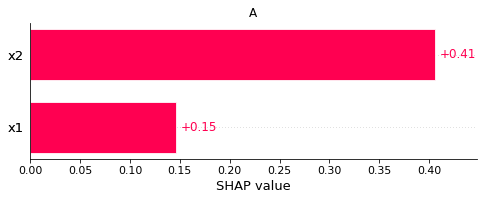

In [8]:
feature_order, feature_importance = calc_feature_order(indiv_shap_values[:, :, 'A.1'])
plot_feature_importance_bar(feature_importance, 'A', feature_order)

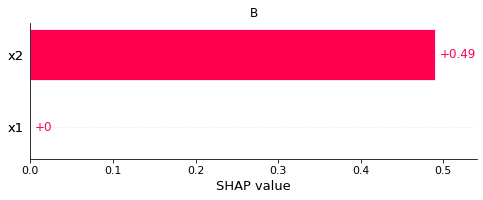

In [9]:
feature_order, feature_importance = calc_feature_order(indiv_shap_values[:, :, 'B.1'])
plot_feature_importance_bar(feature_importance, 'B', feature_order)

In [10]:
%%time
node = make_clustering(comparer, indiv_shap_values)

CPU times: user 29.7 ms, sys: 3.41 ms, total: 33.1 ms
Wall time: 44 ms


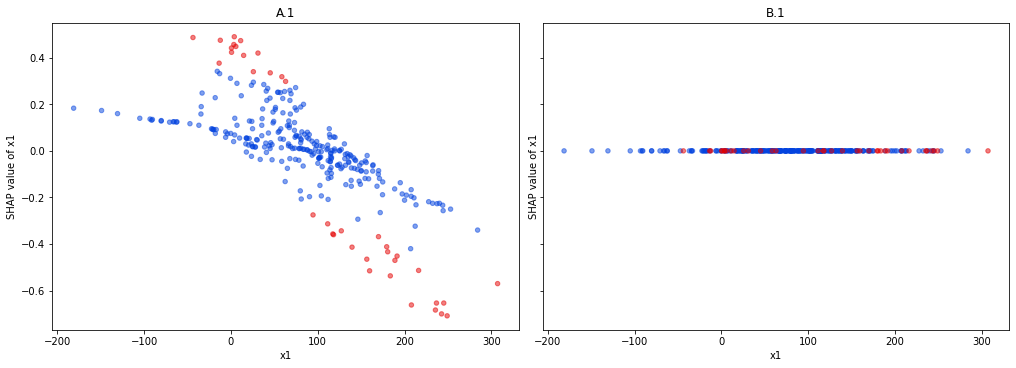

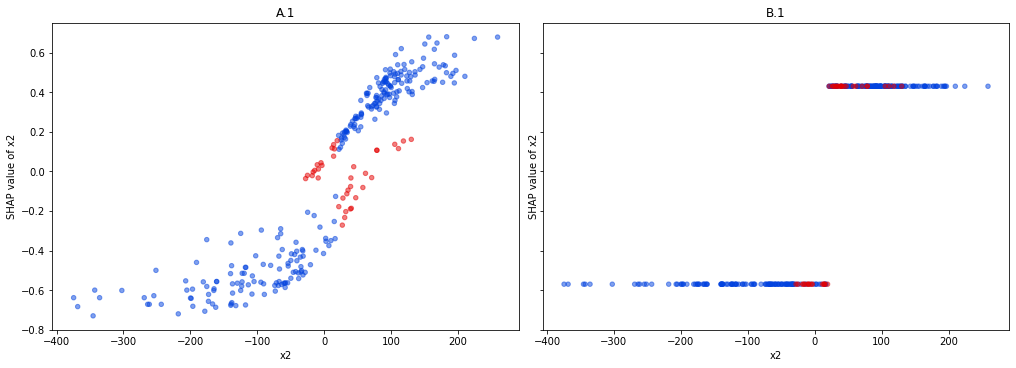

In [11]:
for feature in feature_names:
    node.plot_feature_dependence(feature, alpha=0.5)

# Difference Classifier SHAP Explanations

In [12]:
with open('diffclf.labels.shap', 'rb') as f:
    diffclf_shap_values = pickle.load(f)

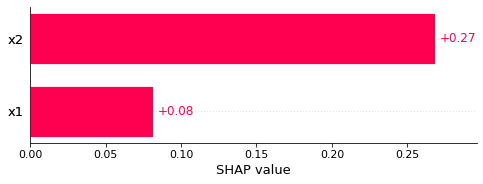

In [14]:
feature_order, feature_importances = calc_feature_order(diffclf_shap_values)
plot_feature_importance_bar(feature_importances)

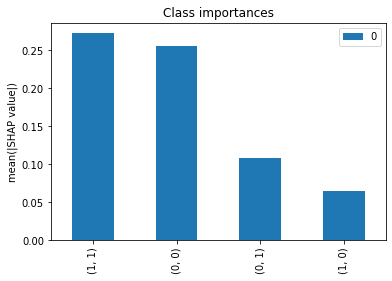

In [15]:
class_order, class_importances = calc_class_order(diffclf_shap_values)
plot_class_importances(class_importances, class_order, diffclf_shap_values.output_names)

## Clustering of Class $(0,1)$ SHAP Values

In [12]:
%%time
node = make_clustering(comparer, diffclf_shap_values, '(0, 1)', ['(0, 0)', '(0, 1)', '(1, 1)'])
node.class_counts, node.distance

CPU times: user 73.5 ms, sys: 3.59 ms, total: 77.1 ms
Wall time: 79.6 ms


((1, 1)    149
 (0, 0)    114
 (0, 1)     22
 (1, 0)     15
 dtype: int64,
 3.1061500000000004)

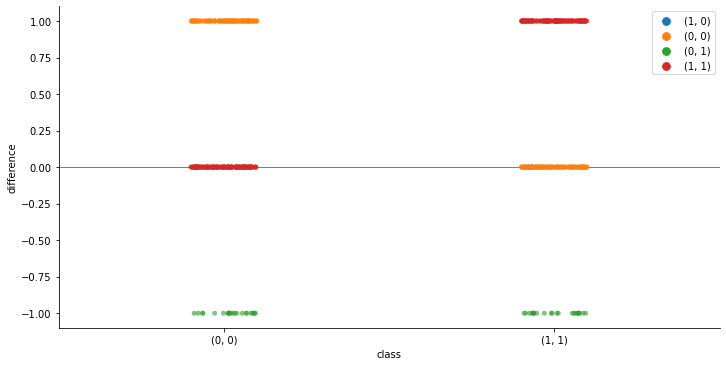

{'(0, 0)': '-1.0 to -1.0', '(1, 1)': '-1.0 to -1.0'}


In [13]:
node.plot_outcome_differences()

### Node RL

In [63]:
node = node.root.get_last_child_before_diff_class_split()
node, node.class_counts, node.distance

(RL,
 (0, 1)    22
 dtype: int64,
 0.7511111111111113)

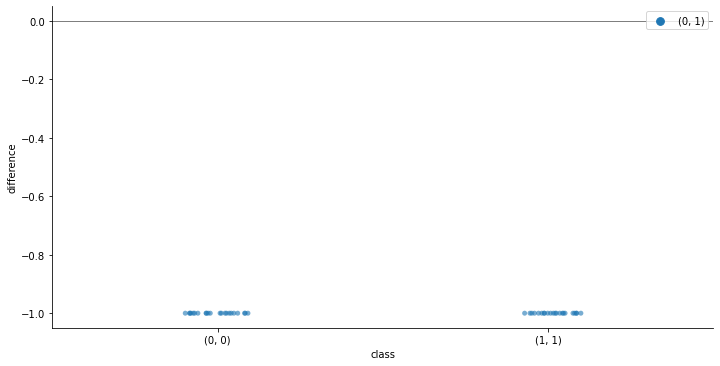

{'(0, 0)': '-1.0 to -1.0', '(1, 1)': '-1.0 to -1.0'}


In [64]:
node.plot_outcome_differences()

94.55361439361346 <= x1
x1 <= 81.0 --> {'(1, 1)': 22}


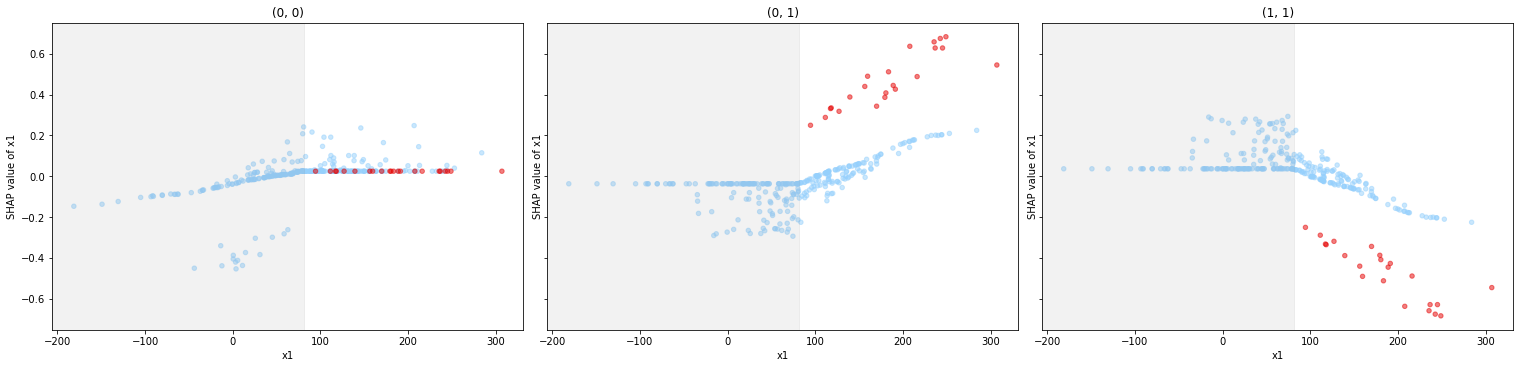

21.71322062603863 <= x2 <= 130.02506989441343
x2 <= 21.0 --> {'(0, 0)': 22}
x2 >= 189.0 --> {'(1, 1)': 22}


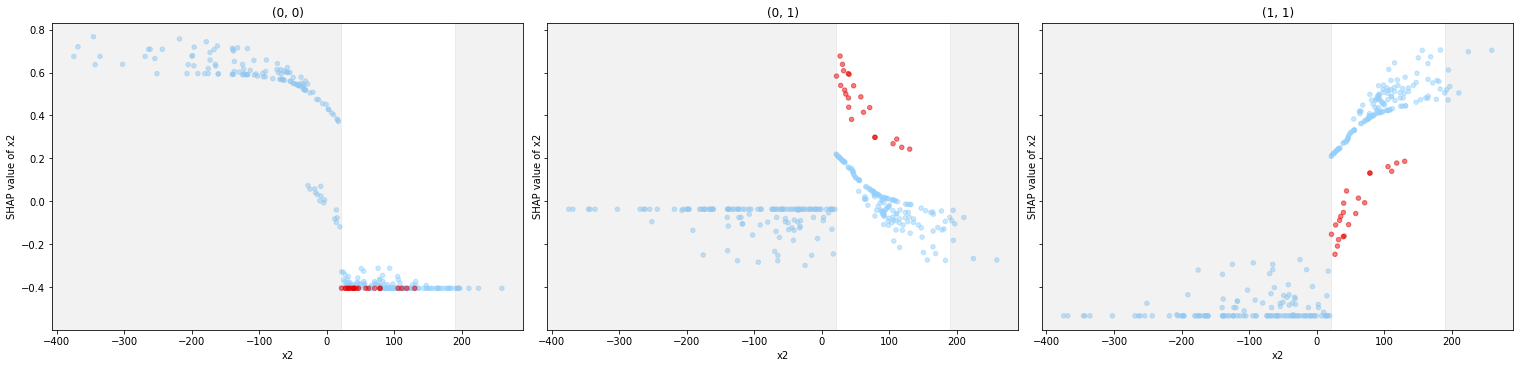

In [65]:
for feature in comparer.feature_names:
    node.describe_feature_differences(feature)
    node.describe_counterfactuals(feature)
    node.root.plot_feature_dependence(feature, focus=node, alpha=0.5)

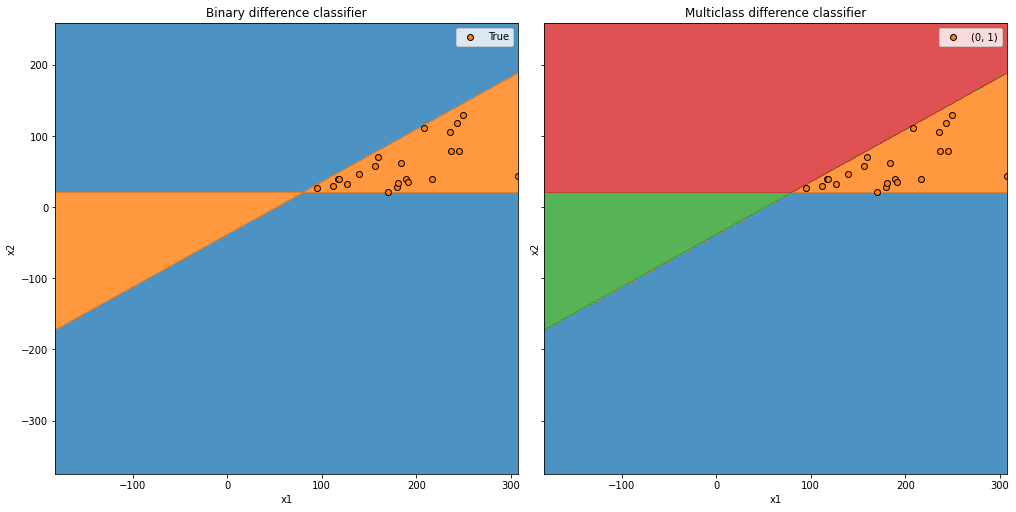

In [18]:
comparer.plot_decision_boundaries(node.shap_values.data, xlim=xlim, ylim=ylim)

### Node RLL

In [19]:
node = node.get_left().get_last_child_before_diff_class_split()
node, node.class_counts, node.distance

(RLL,
 (0, 1)    6
 dtype: int64,
 0.012100000000000017)

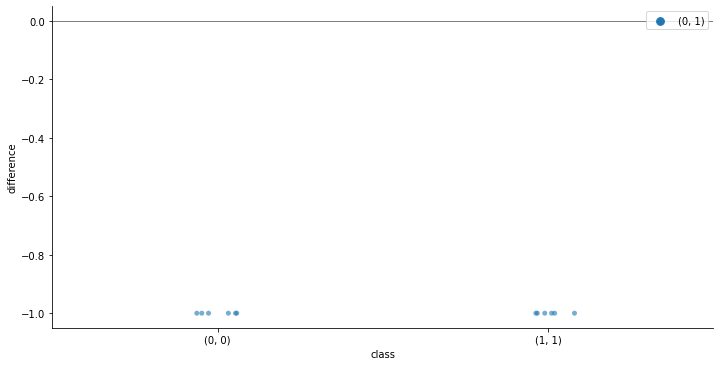

{'(0, 0)': '-1.0 to -1.0', '(1, 1)': '-1.0 to -1.0'}


In [20]:
node.plot_outcome_differences()

207.88011354547447 <= x1 <= 249.04127642882824
x1 <= 158.0 --> {'(1, 1)': 6}


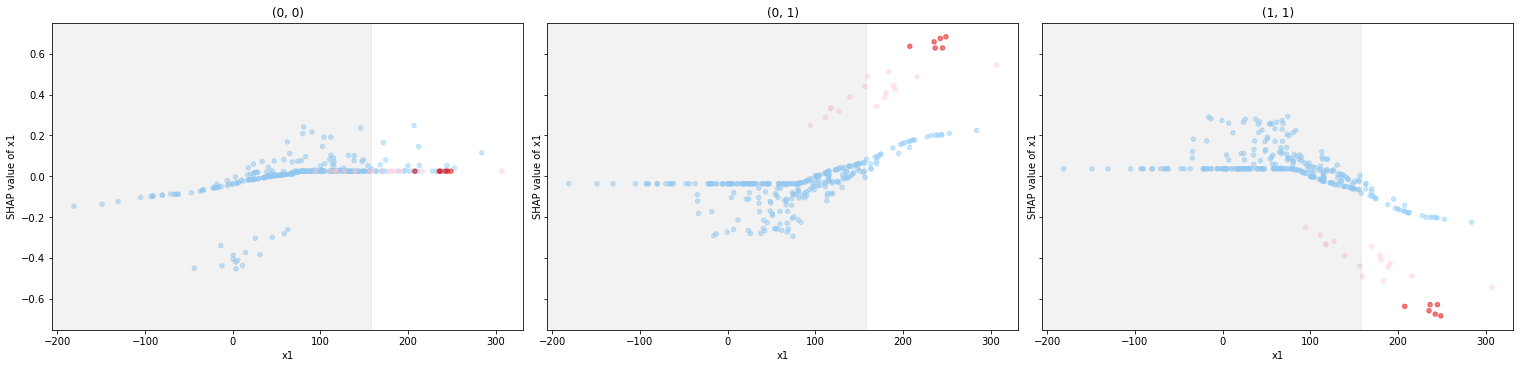

78.44525088412485 <= x2 <= 130.02506989441343
x2 <= 21.0 --> {'(0, 0)': 6}
x2 >= 146.0 --> {'(1, 1)': 6}


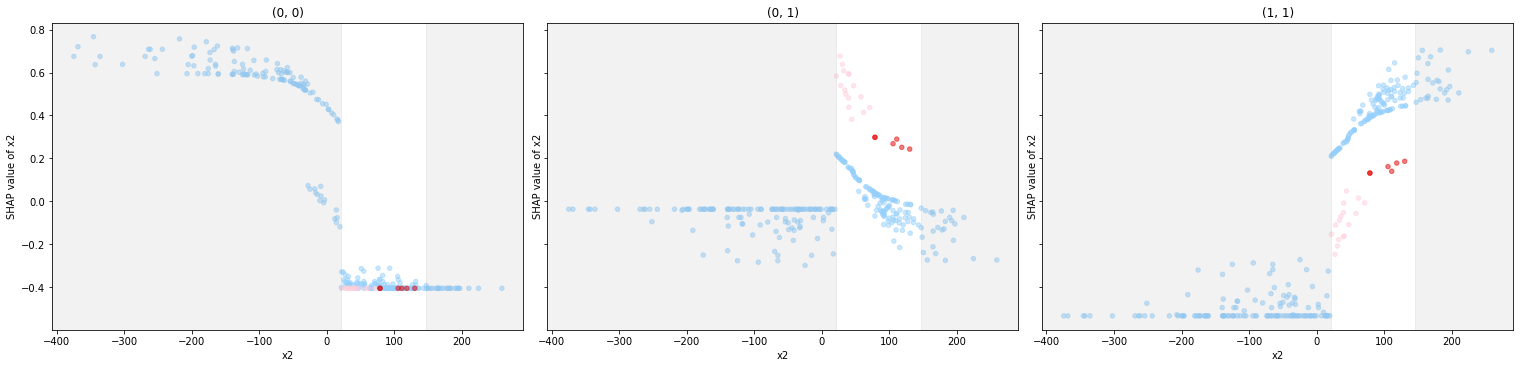

In [21]:
for feature in comparer.feature_names:
    node.describe_feature_differences(feature)
    node.describe_counterfactuals(feature)
    node.root.plot_feature_dependence(feature, focus=node, alpha=0.5)

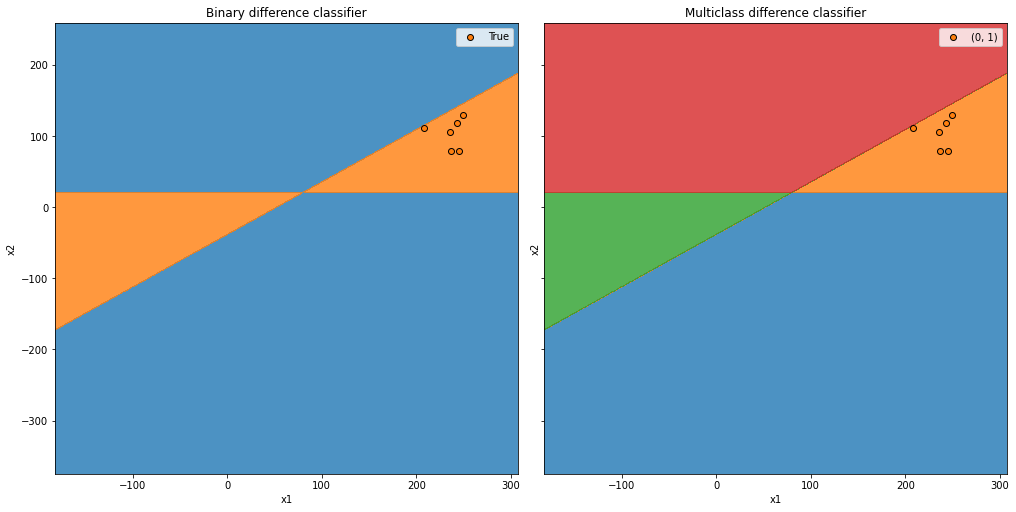

In [22]:
comparer.plot_decision_boundaries(node.shap_values.data, xlim=xlim, ylim=ylim)

### Node RLLL

In [23]:
node = node.get_left().get_last_child_before_diff_class_split()
node, node.class_counts, node.distance

(RLLL,
 (0, 1)    3
 dtype: int64,
 0.0002777777777777786)

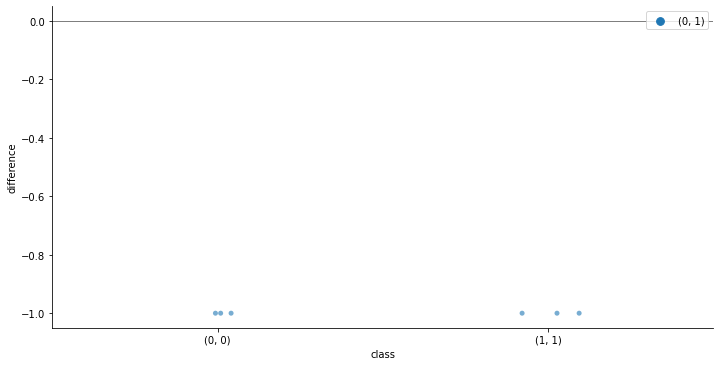

{'(0, 0)': '-1.0 to -1.0', '(1, 1)': '-1.0 to -1.0'}


In [24]:
node.plot_outcome_differences()

207.88011354547447 <= x1 <= 245.17590166375376
x1 <= 158.0 --> {'(1, 1)': 3}


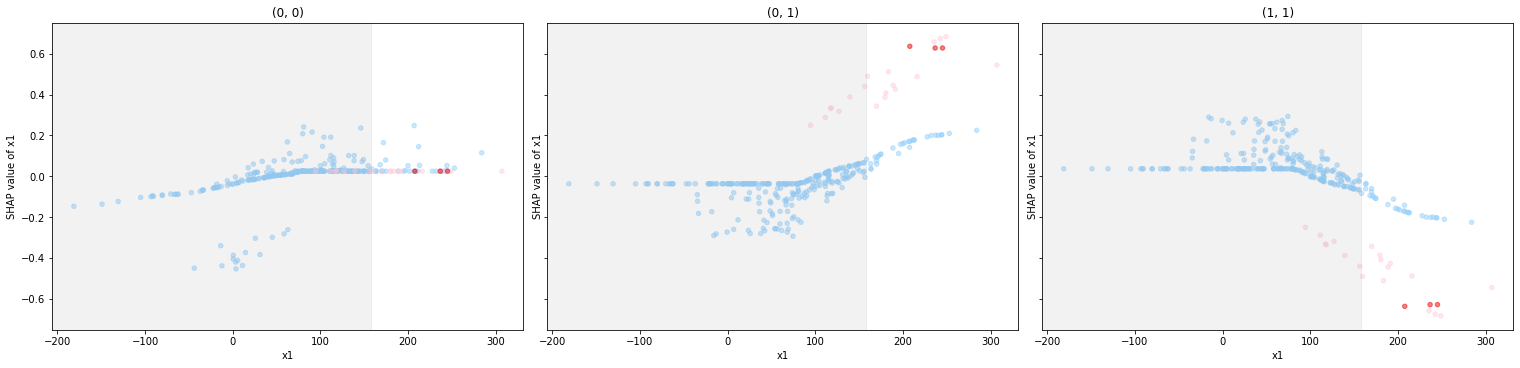

78.44525088412485 <= x2 <= 110.8536857546654
x2 <= 21.0 --> {'(0, 0)': 3}
x2 >= 143.0 --> {'(1, 1)': 3}


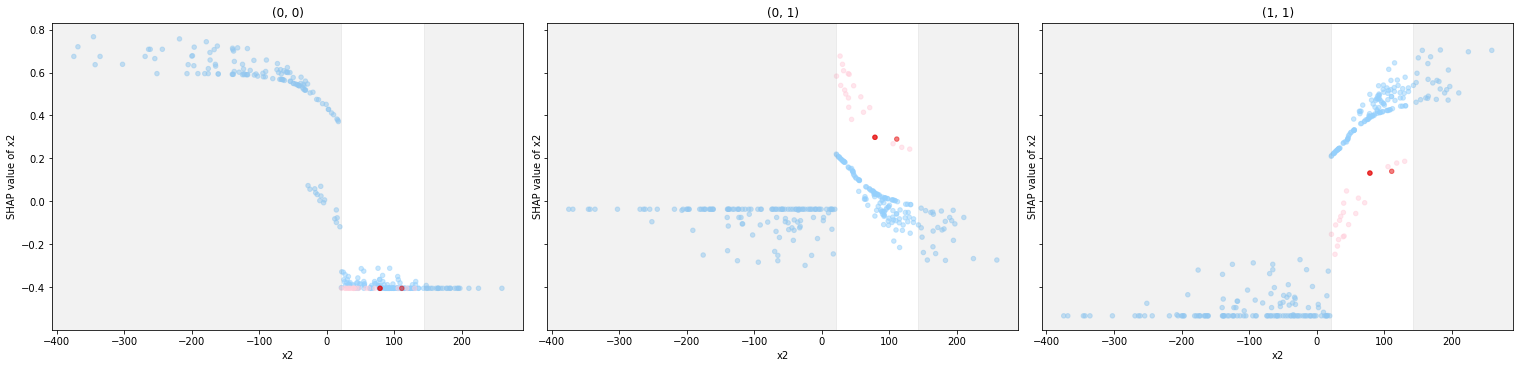

In [25]:
for feature in comparer.feature_names:
    node.describe_feature_differences(feature)
    node.describe_counterfactuals(feature)
    node.root.plot_feature_dependence(feature, focus=node, alpha=0.5)

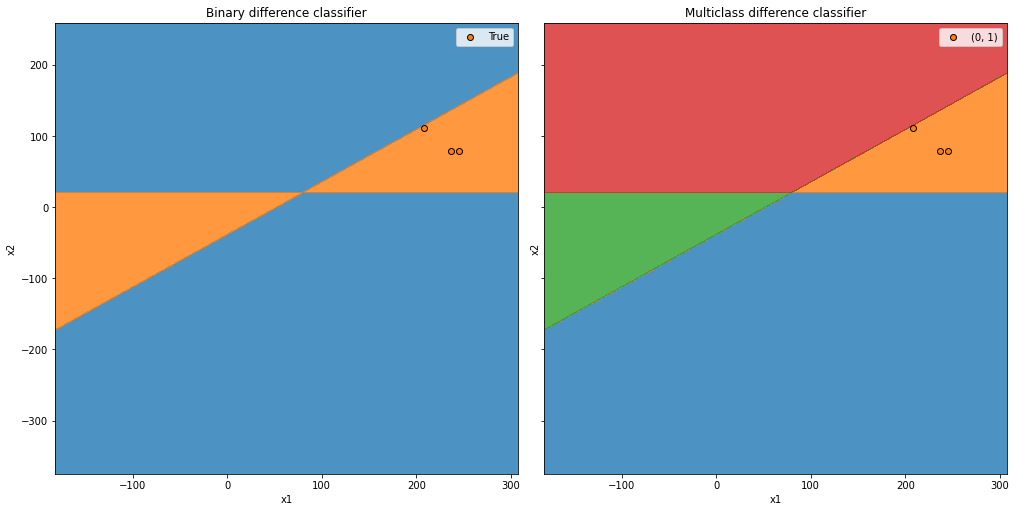

In [26]:
comparer.plot_decision_boundaries(node.shap_values.data, xlim=xlim, ylim=ylim)

### Node RLLLL

In [27]:
node = node.get_left().get_last_child_before_diff_class_split()
node, node.class_counts, node.distance

(RLLLL,
 (0, 1)    1
 dtype: int64,
 0)

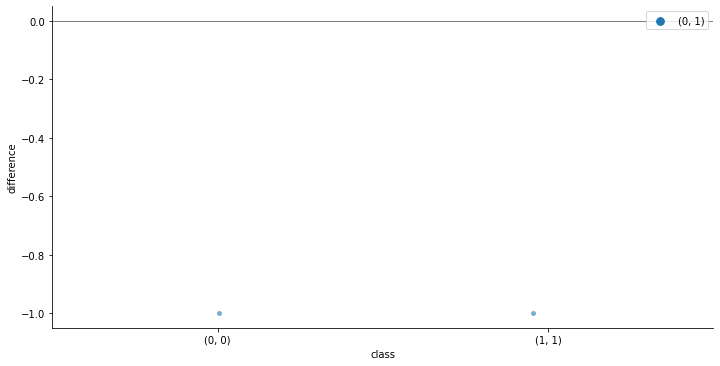

{'(0, 0)': '-1.0 to -1.0', '(1, 1)': '-1.0 to -1.0'}


In [28]:
node.plot_outcome_differences()

x1 == 207.88011354547447
x1 <= 201.0 --> {'(1, 1)': 1}


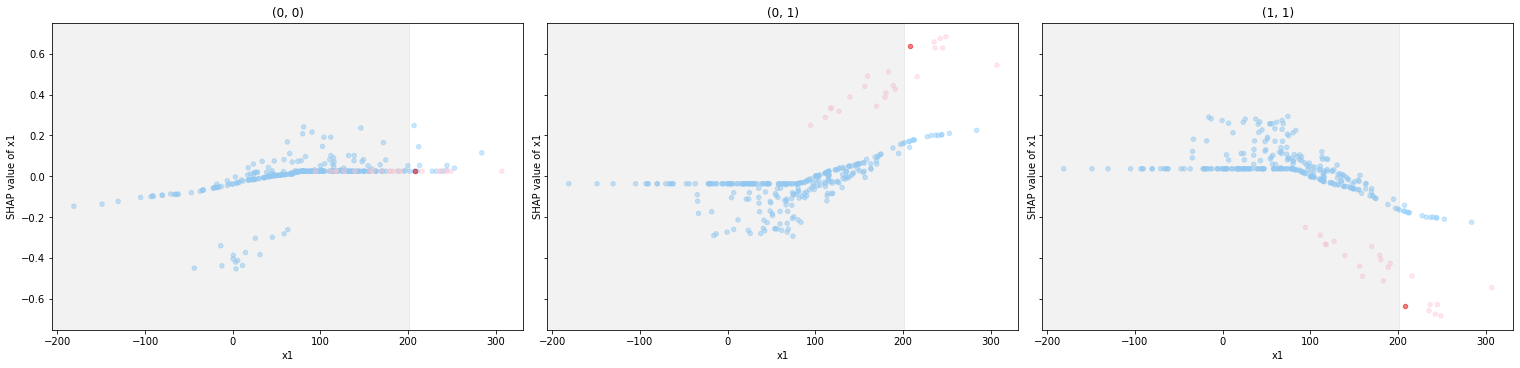

x2 == 110.8536857546654
x2 <= 21.0 --> {'(0, 0)': 1}
x2 >= 116.0 --> {'(1, 1)': 1}


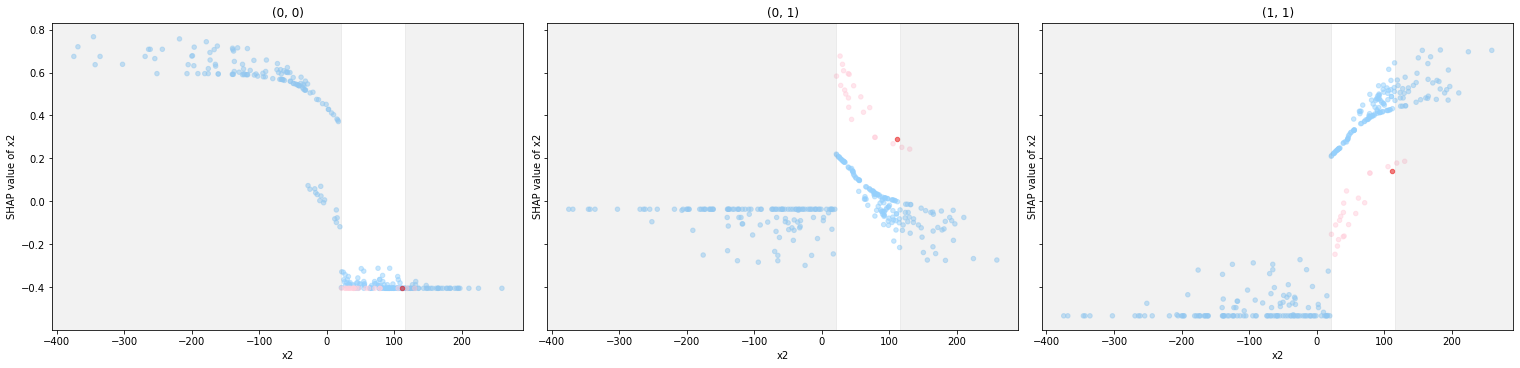

In [29]:
for feature in comparer.feature_names:
    node.describe_feature_differences(feature)
    node.describe_counterfactuals(feature)
    node.root.plot_feature_dependence(feature, focus=node, alpha=0.5)

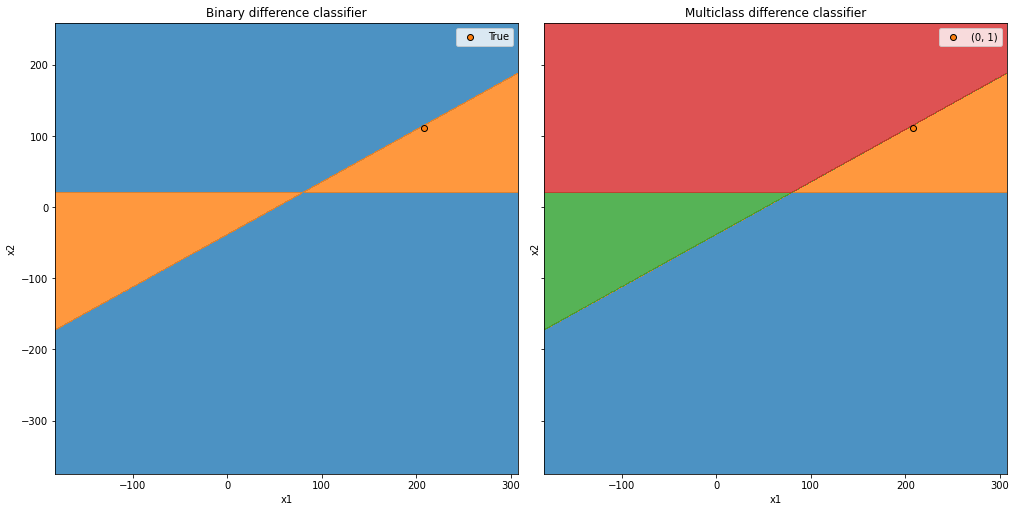

In [30]:
comparer.plot_decision_boundaries(node.shap_values.data, xlim=xlim, ylim=ylim)

### Node RLLLR

In [31]:
node = node.parent.get_right()
node, node.class_counts, node.distance

(RLLLR,
 (0, 1)    2
 dtype: int64,
 0.0)

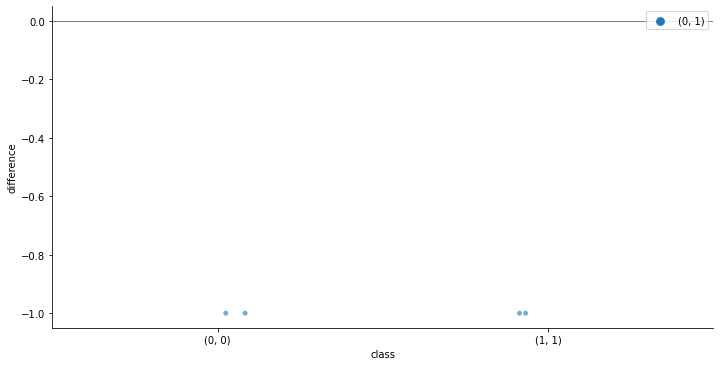

{'(0, 0)': '-1.0 to -1.0', '(1, 1)': '-1.0 to -1.0'}


In [32]:
node.plot_outcome_differences()

236.75428302388113 <= x1 <= 245.17590166375376
x1 <= 158.0 --> {'(1, 1)': 2}


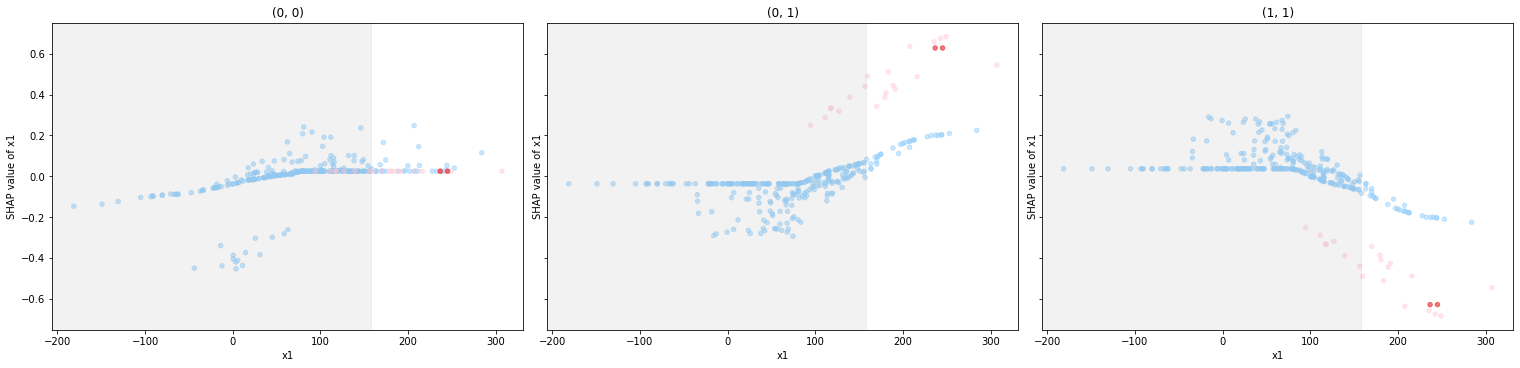

78.44525088412485 <= x2 <= 78.69646042050337
x2 <= 21.0 --> {'(0, 0)': 2}
x2 >= 143.0 --> {'(1, 1)': 2}


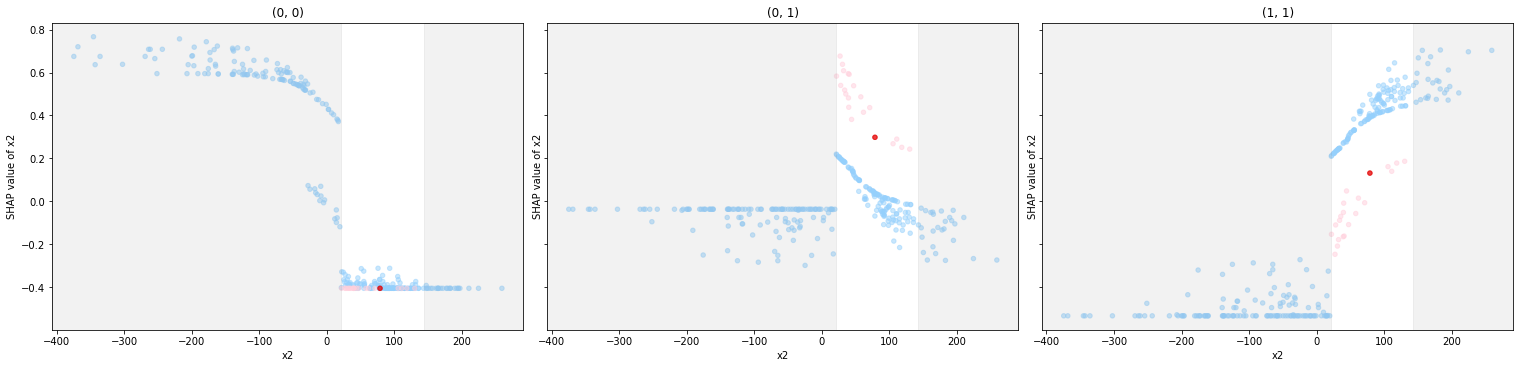

In [33]:
for feature in comparer.feature_names:
    node.describe_feature_differences(feature)
    node.describe_counterfactuals(feature)
    node.root.plot_feature_dependence(feature, focus=node, alpha=0.5)

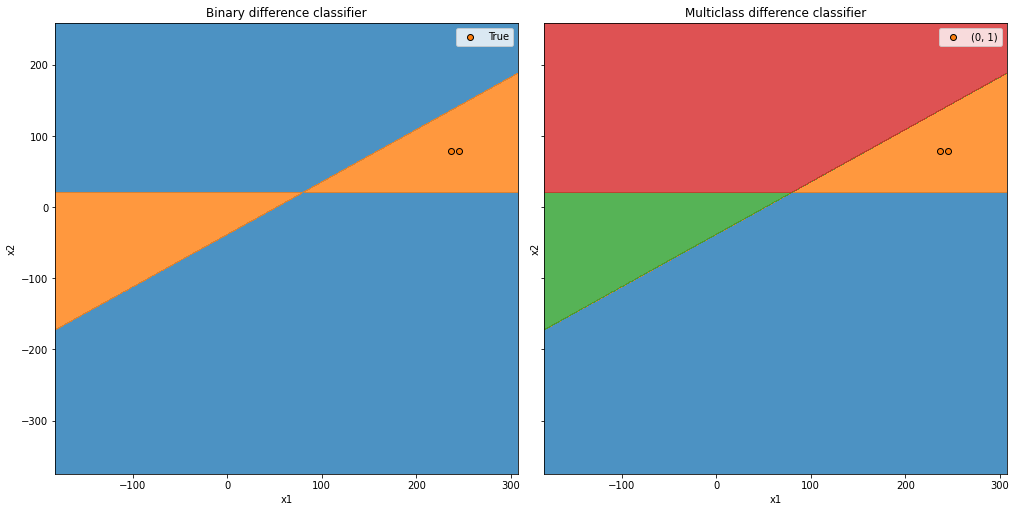

In [34]:
comparer.plot_decision_boundaries(node.shap_values.data, xlim=xlim, ylim=ylim)

### Node RLLR

In [35]:
node = node.root.get('RLLR')
node, node.class_counts, node.distance

(RLLR,
 (0, 1)    3
 dtype: int64,
 0.0025000000000000044)

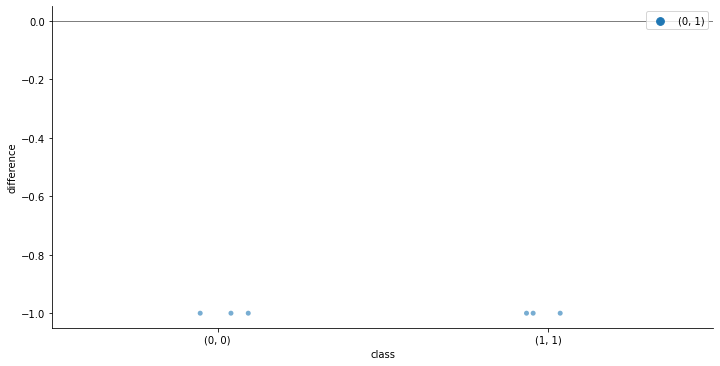

{'(0, 0)': '-1.0 to -1.0', '(1, 1)': '-1.0 to -1.0'}


In [36]:
node.plot_outcome_differences()

235.55608825101464 <= x1 <= 249.04127642882824
x1 <= 194.0 --> {'(1, 1)': 3}


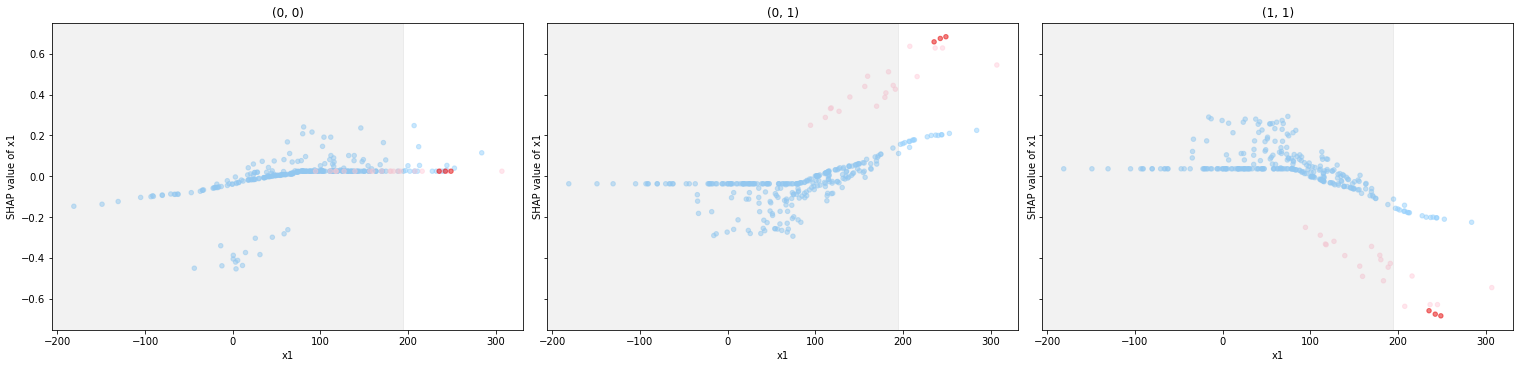

105.35039011208185 <= x2 <= 130.02506989441343
x2 <= 21.0 --> {'(0, 0)': 3}
x2 >= 146.0 --> {'(1, 1)': 3}


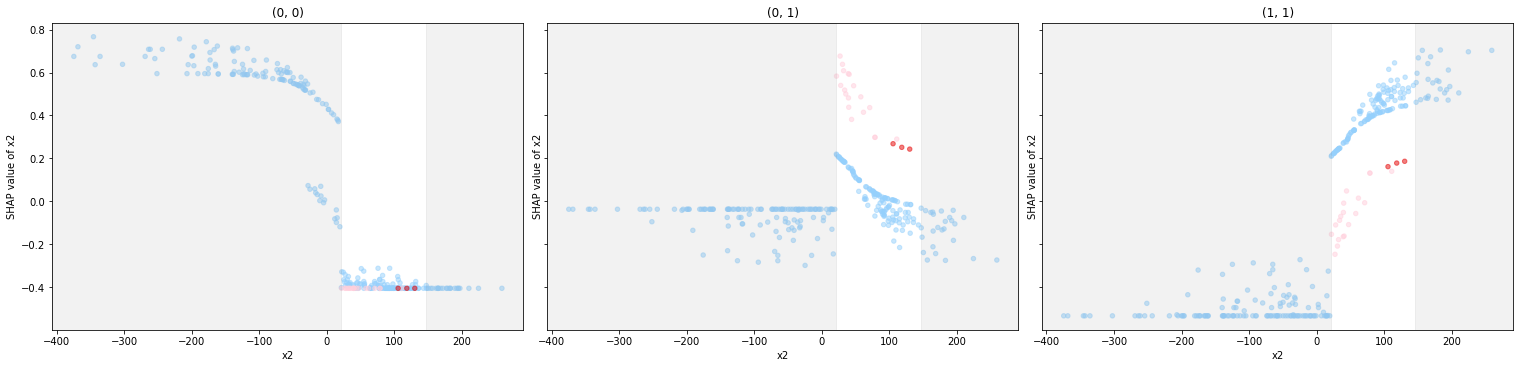

In [37]:
for feature in comparer.feature_names:
    node.describe_feature_differences(feature)
    node.describe_counterfactuals(feature)
    node.root.plot_feature_dependence(feature, focus=node, alpha=0.5)

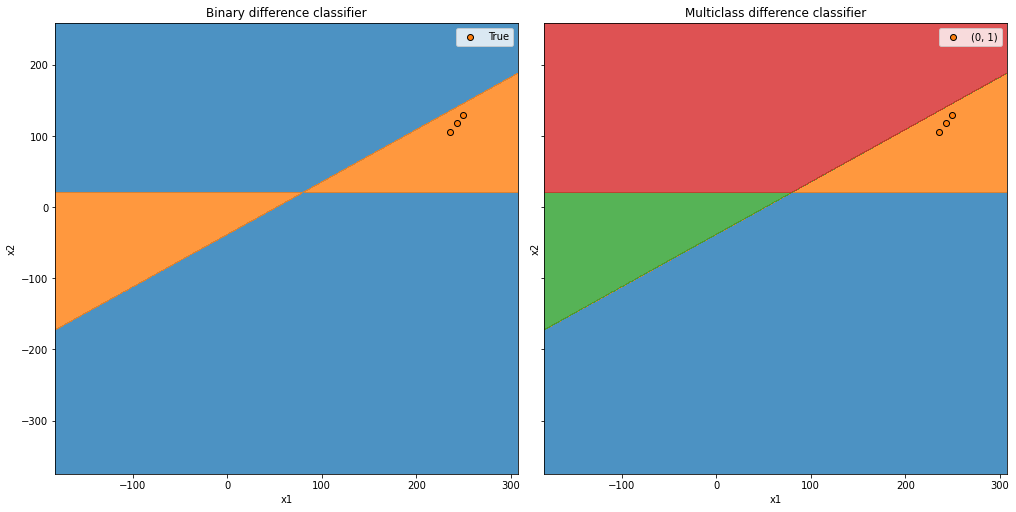

In [38]:
comparer.plot_decision_boundaries(node.shap_values.data, xlim=xlim, ylim=ylim)

### Node RLR

In [39]:
node = node.root.get('RLR')
node, node.class_counts, node.distance

(RLR,
 (0, 1)    16
 dtype: int64,
 0.3481000000000001)

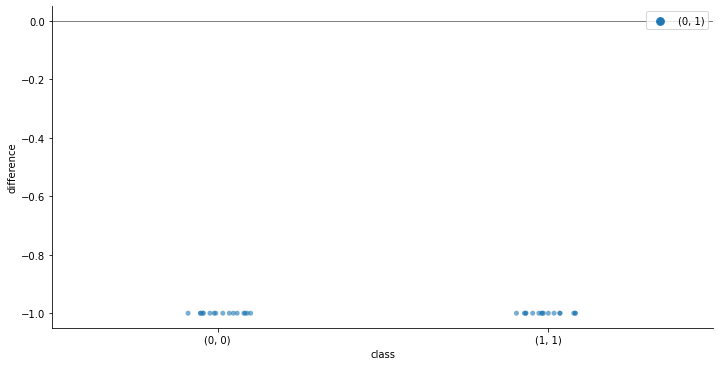

{'(0, 0)': '-1.0 to -1.0', '(1, 1)': '-1.0 to -1.0'}


In [40]:
node.plot_outcome_differences()

94.55361439361346 <= x1
x1 <= 81.0 --> {'(1, 1)': 16}


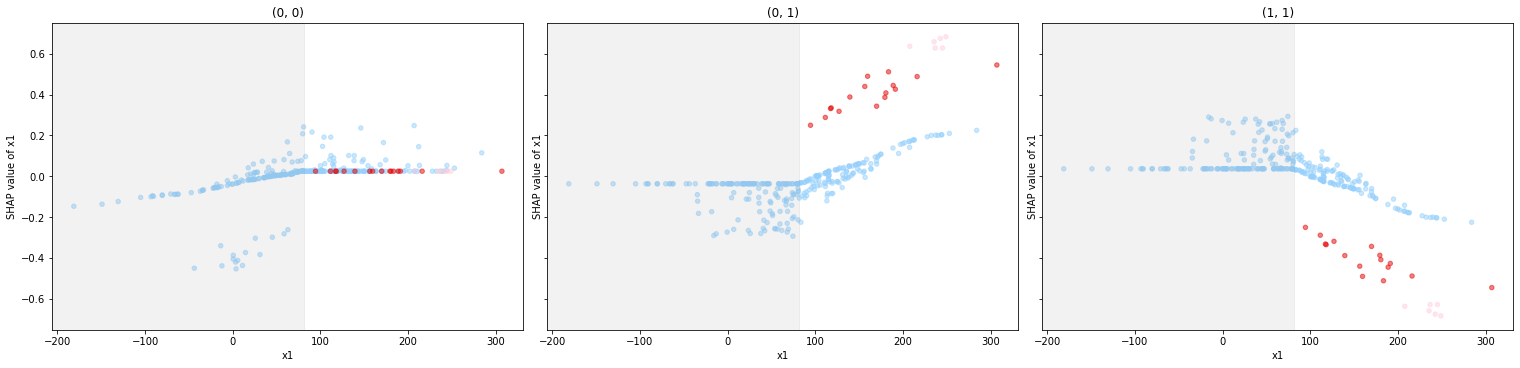

21.71322062603863 <= x2 <= 70.8584634570066
x2 <= 21.0 --> {'(0, 0)': 16}
x2 >= 189.0 --> {'(1, 1)': 16}


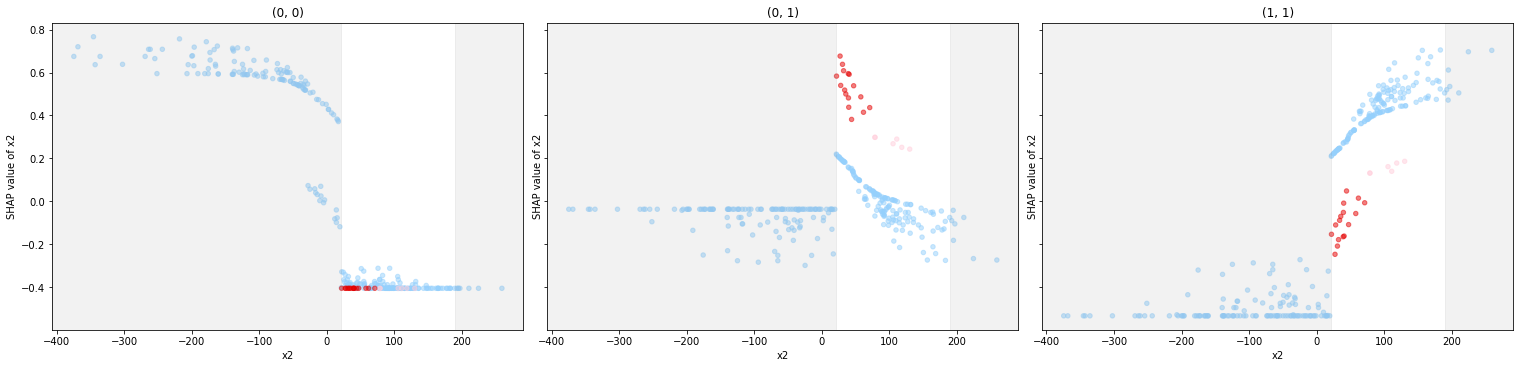

In [41]:
for feature in comparer.feature_names:
    node.describe_feature_differences(feature)
    node.describe_counterfactuals(feature)
    node.root.plot_feature_dependence(feature, focus=node, alpha=0.5)

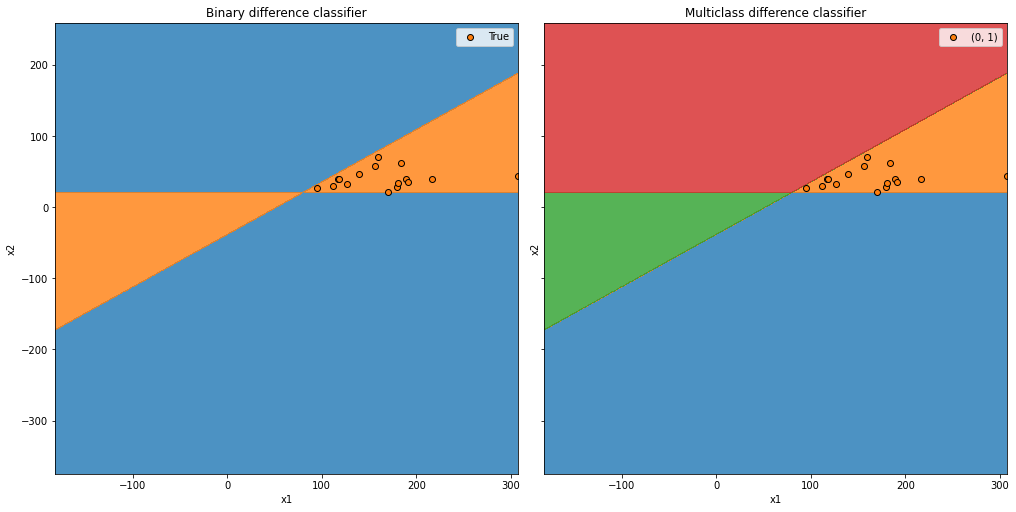

In [42]:
comparer.plot_decision_boundaries(node.shap_values.data, xlim=xlim, ylim=ylim)

### Node RLRL

In [47]:
node = node.root.get('RLRL')
node, node.class_counts, node.distance

(RLRL,
 (0, 1)    6
 dtype: int64,
 0.03484444444444443)

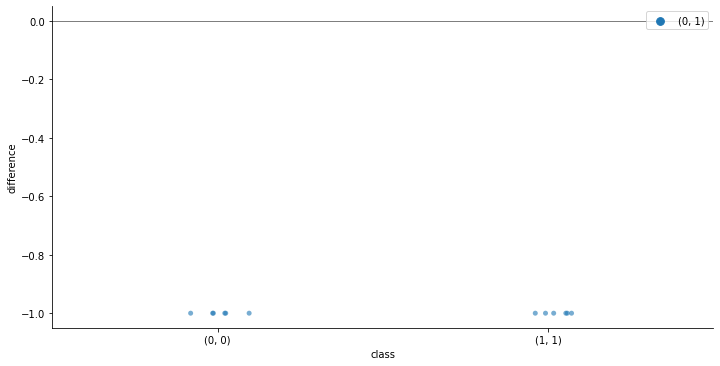

{'(0, 0)': '-1.0 to -1.0', '(1, 1)': '-1.0 to -1.0'}


In [48]:
node.plot_outcome_differences()

94.55361439361346 <= x1 <= 169.96479241673015
x1 <= 81.0 --> {'(1, 1)': 6}


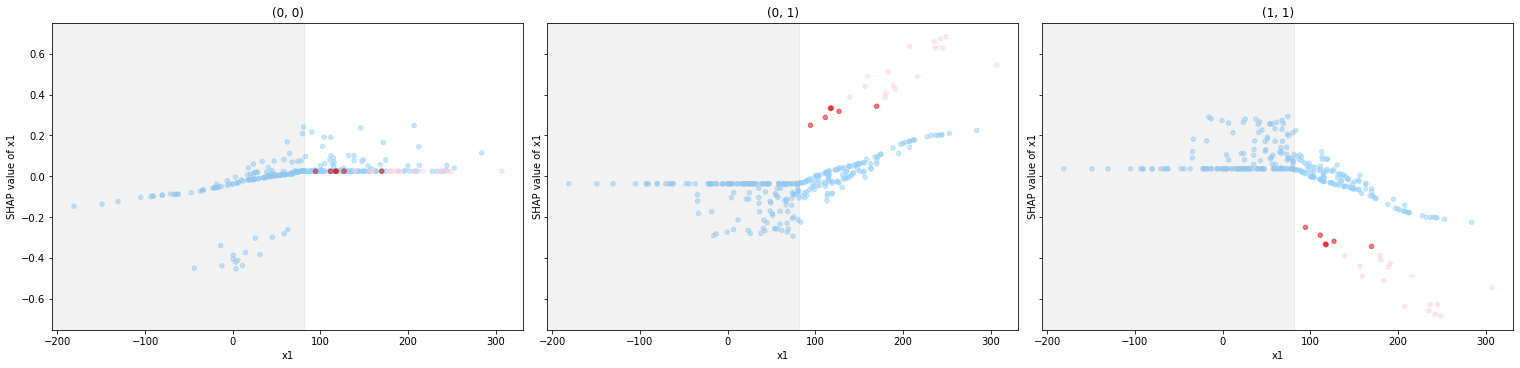

21.71322062603863 <= x2 <= 40.42060515353158
x2 <= 21.0 --> {'(0, 0)': 6}
x2 >= 88.0 --> {'(1, 1)': 6}


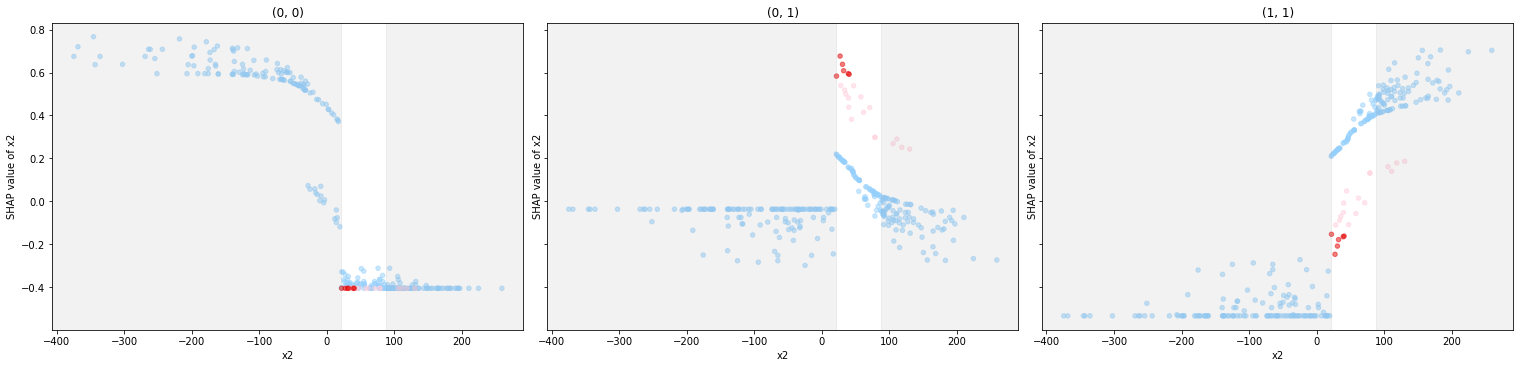

In [49]:
for feature in comparer.feature_names:
    node.describe_feature_differences(feature)
    node.describe_counterfactuals(feature)
    node.root.plot_feature_dependence(feature, focus=node, alpha=0.5)

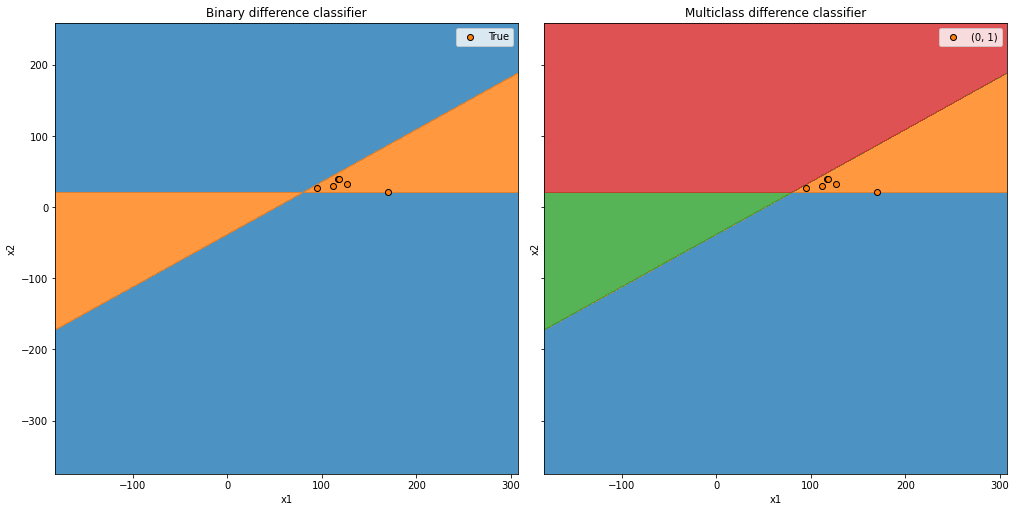

In [50]:
comparer.plot_decision_boundaries(node.shap_values.data, xlim=xlim, ylim=ylim)

### Node RLRLL

In [51]:
node = node.root.get('RLRLL')
node, node.class_counts, node.distance

(RLRLL,
 (0, 1)    4
 dtype: int64,
 0.002499999999999989)

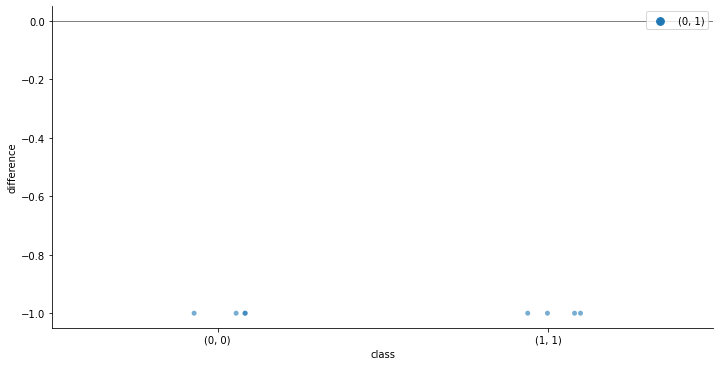

{'(0, 0)': '-1.0 to -1.0', '(1, 1)': '-1.0 to -1.0'}


In [52]:
node.plot_outcome_differences()

117.36607682827199 <= x1 <= 169.96479241673015
x1 <= 81.0 --> {'(1, 1)': 4}


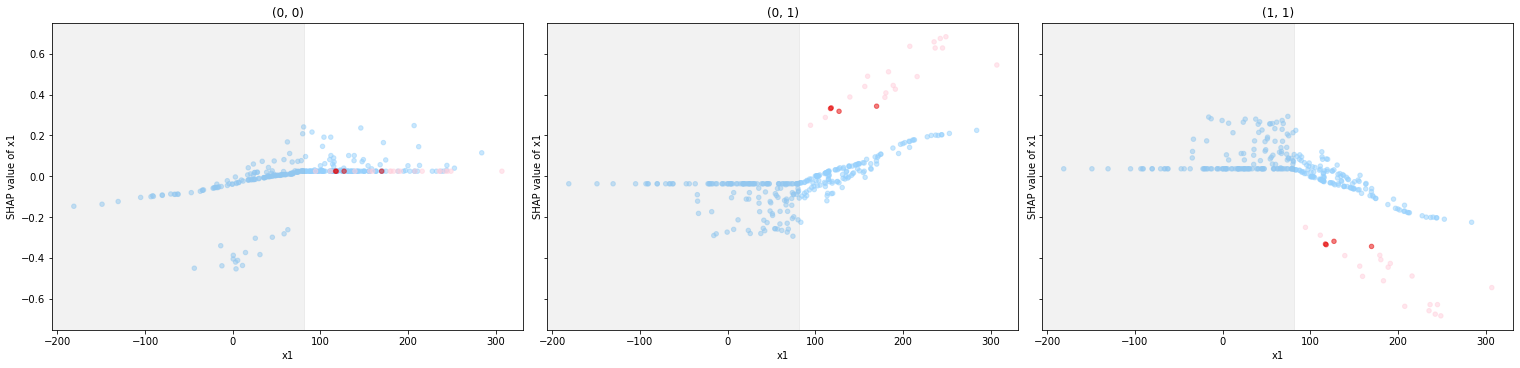

21.71322062603863 <= x2 <= 40.42060515353158
x2 <= 21.0 --> {'(0, 0)': 4}
x2 >= 88.0 --> {'(1, 1)': 4}


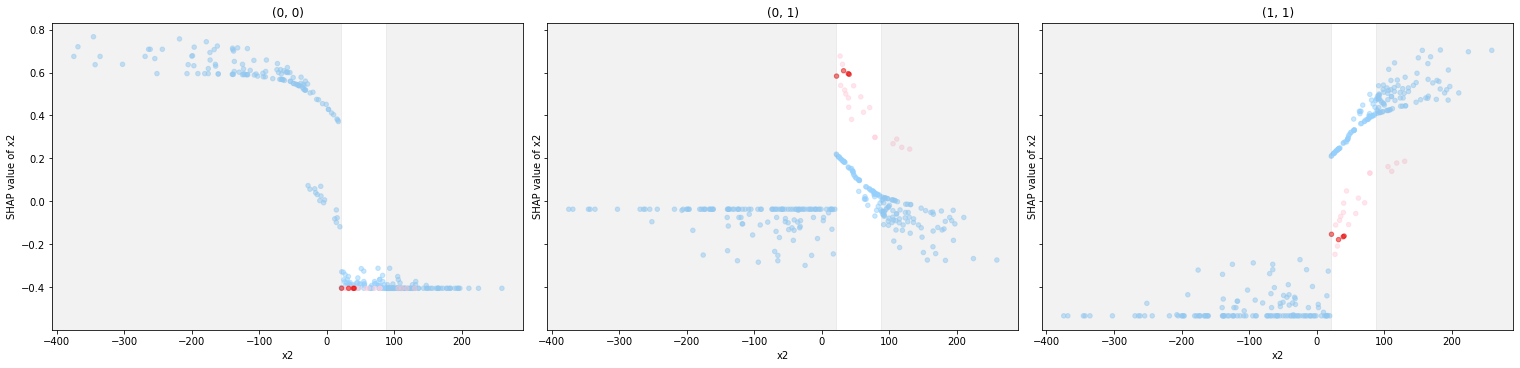

In [53]:
for feature in comparer.feature_names:
    node.describe_feature_differences(feature)
    node.describe_counterfactuals(feature)
    node.root.plot_feature_dependence(feature, focus=node, alpha=0.5)

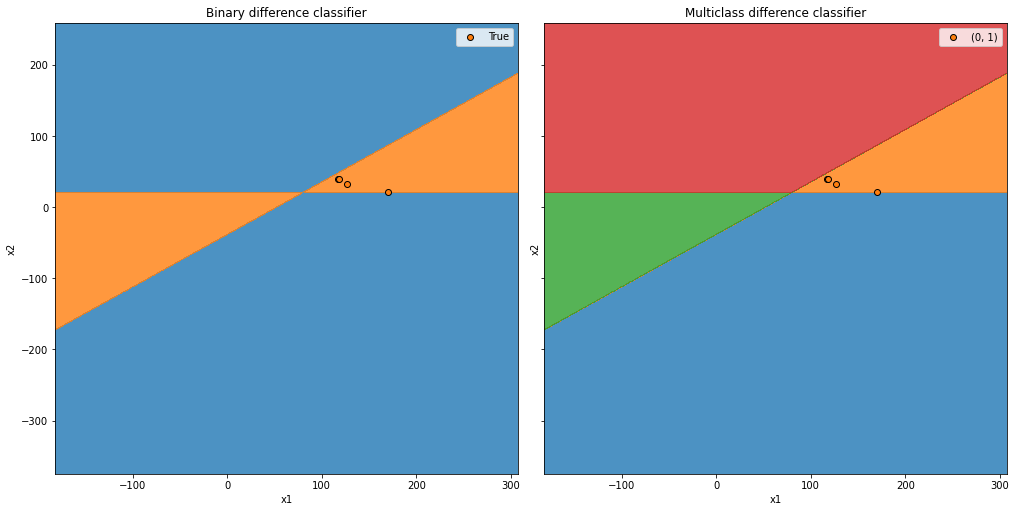

In [54]:
comparer.plot_decision_boundaries(node.shap_values.data, xlim=xlim, ylim=ylim)

### Node RLRLLL

In [55]:
node = node.root.get('RLRLLL')
node, node.class_counts, node.distance

(RLRLLL,
 (0, 1)    1
 dtype: int64,
 0)

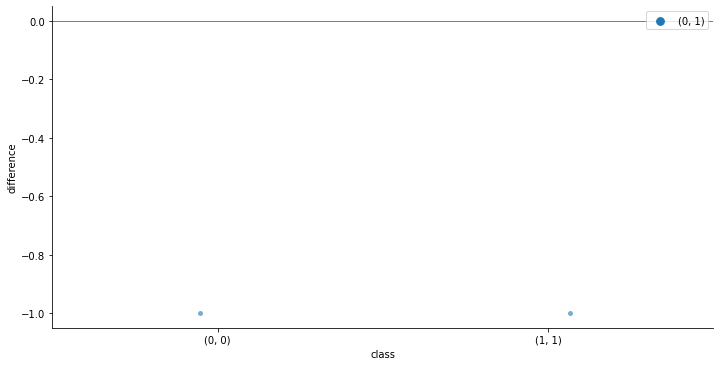

{'(0, 0)': '-1.0 to -1.0', '(1, 1)': '-1.0 to -1.0'}


In [56]:
node.plot_outcome_differences()

x1 == 127.11742133952461
x1 <= 95.0 --> {'(1, 1)': 1}


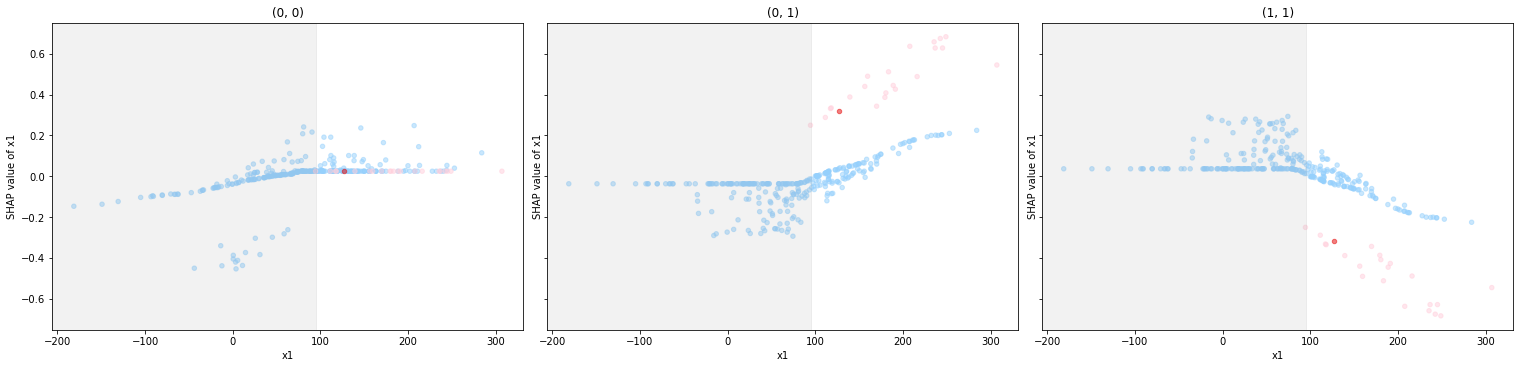

x2 == 32.15872408629021
x2 <= 21.0 --> {'(0, 0)': 1}
x2 >= 56.0 --> {'(1, 1)': 1}


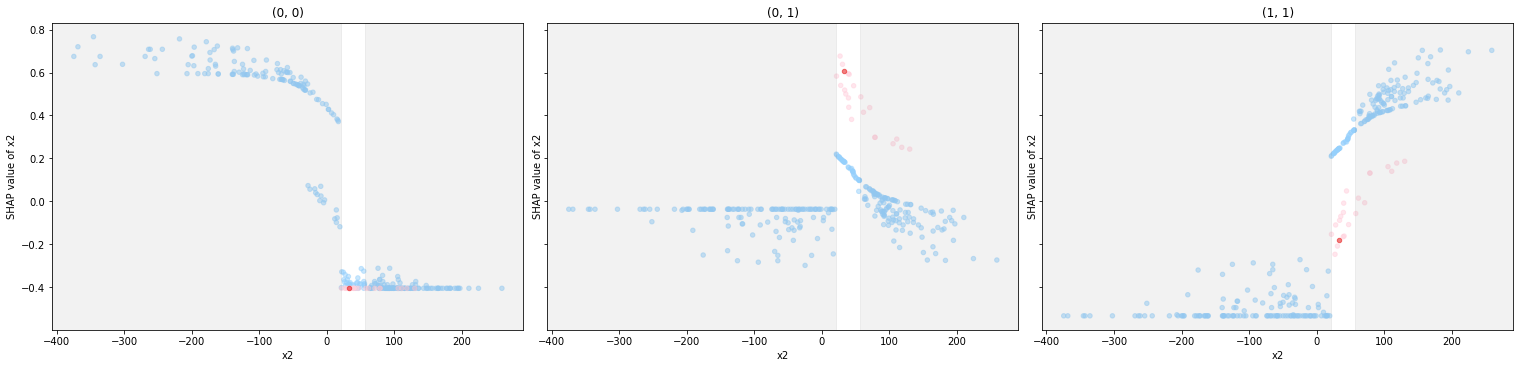

In [57]:
for feature in comparer.feature_names:
    node.describe_feature_differences(feature)
    node.describe_counterfactuals(feature)
    node.root.plot_feature_dependence(feature, focus=node, alpha=0.5)

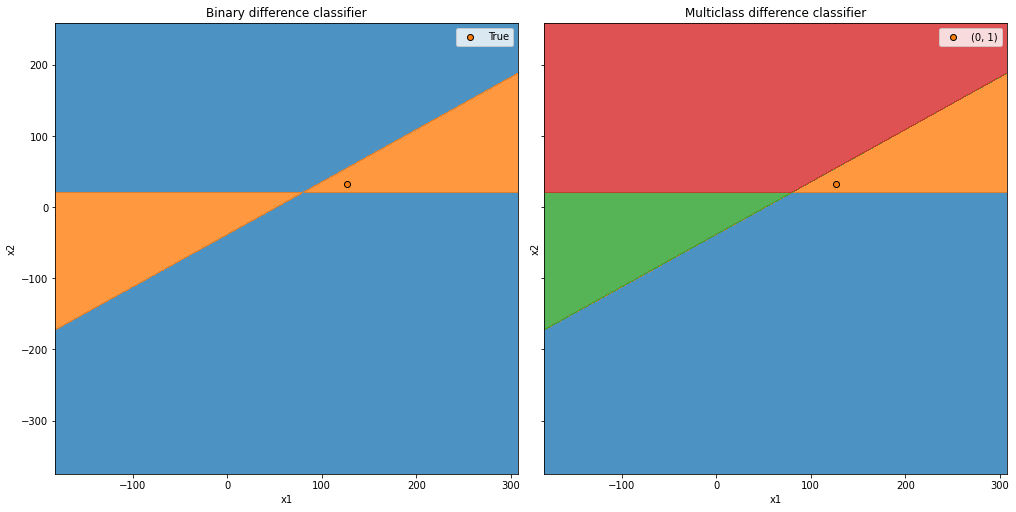

In [58]:
comparer.plot_decision_boundaries(node.shap_values.data, xlim=xlim, ylim=ylim)

### Node RLRLLR

In [59]:
node = node.root.get('RLRLLR')
node, node.class_counts, node.distance

(RLRLLR,
 (0, 1)    3
 dtype: int64,
 0.0005444444444444412)

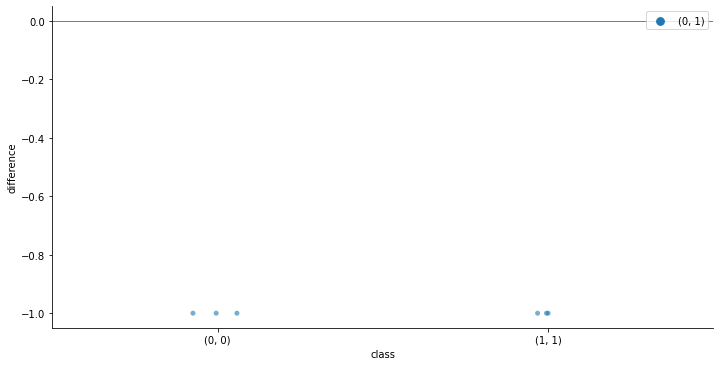

{'(0, 0)': '-1.0 to -1.0', '(1, 1)': '-1.0 to -1.0'}


In [60]:
node.plot_outcome_differences()

117.36607682827199 <= x1 <= 169.96479241673015
x1 <= 81.0 --> {'(1, 1)': 3}


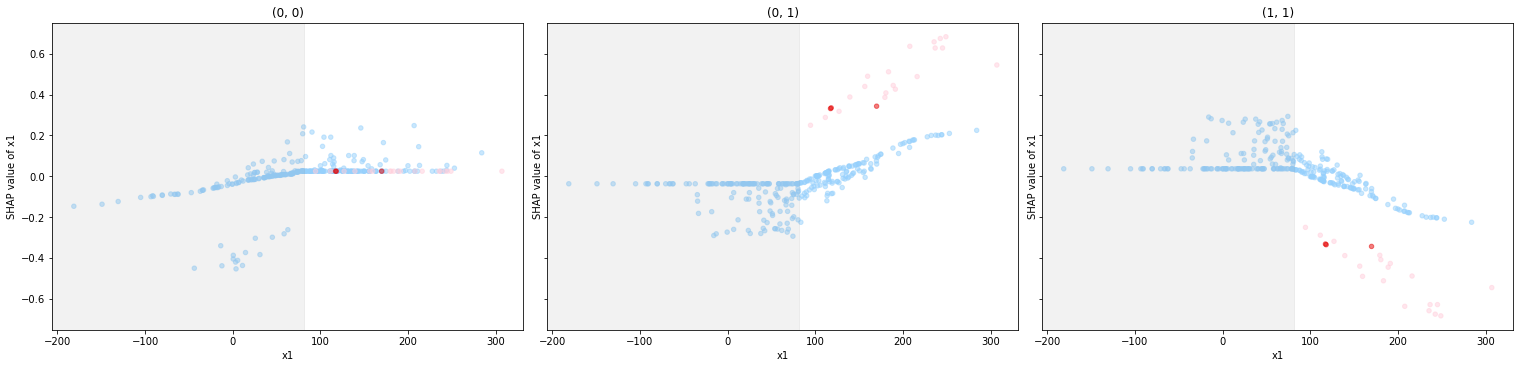

21.71322062603863 <= x2 <= 40.42060515353158
x2 <= 21.0 --> {'(0, 0)': 3}
x2 >= 88.0 --> {'(1, 1)': 3}


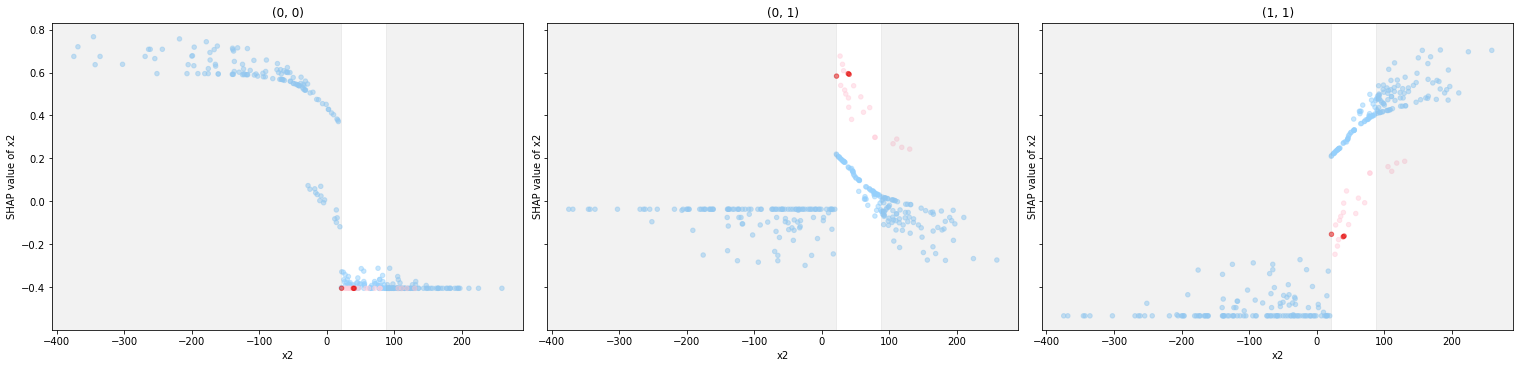

In [61]:
for feature in comparer.feature_names:
    node.describe_feature_differences(feature)
    node.describe_counterfactuals(feature)
    node.root.plot_feature_dependence(feature, focus=node, alpha=0.5)

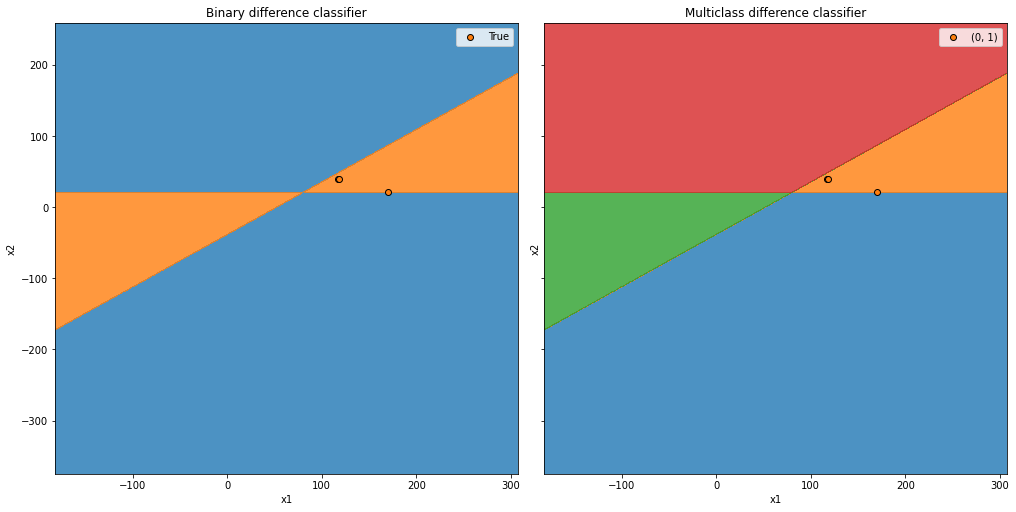

In [62]:
comparer.plot_decision_boundaries(node.shap_values.data, xlim=xlim, ylim=ylim)